# Part 2 - Forecasting Queretaro industrial activity
### Diego Díaz Ayala A01770236

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Identifying seasonality in a time-series

### Read dataset.

First we read the dataset, and we add a column with the natural logarithm of the column we want to predict.

In [2]:
df = pd.read_csv('QRO.csv')
df['ln_valor'] = np.log(df['Valor'])
df

,Periodo,Valor,ln_valor
0,2003/01,65.234491,4.177988
1,2003/02,64.750420,4.170540
2,2003/03,61.444991,4.118142
3,2003/04,64.953065,4.173665
4,2003/05,59.522348,4.086352
...,...,...,...
241,2023/02,89.168194,4.490524
242,2023/03,103.384331,4.638453
243,2023/04,91.876916,4.520450
244,2023/05,101.002534,4.615146


### Plot natural logarithm of the value

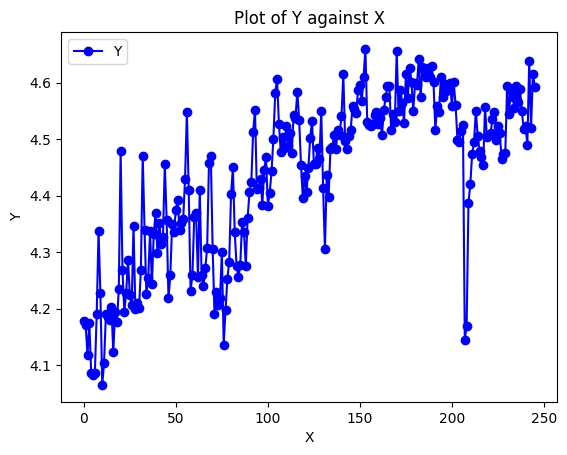

In [3]:
plt.plot(df['ln_valor'], marker='o', color='b', label='Y')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Plot of Y against X')
plt.legend()
plt.show()

### Plot the difference of log

Since we see a clear seasonality pattern, we are going to use the difference of log of the series.

We start by plotting the seasonal difference of the log, which is the annual % growth of Indice de Actividad Industrial in the city of Querétaro:

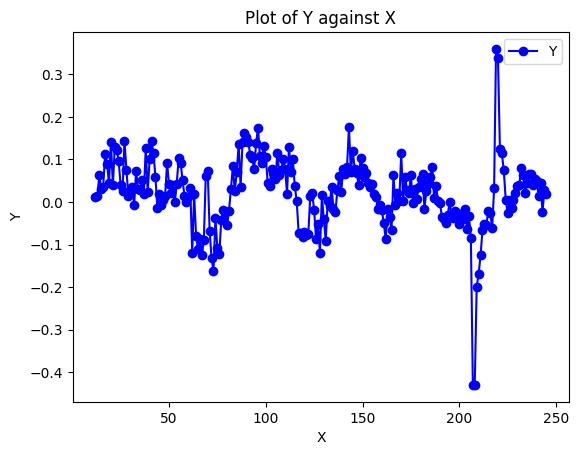

In [4]:
df['ln_diff12'] = df['ln_valor'].diff(12)

plt.plot(df['ln_diff12'], marker='o', color='b', label='Y')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Plot of Y against X')
plt.legend()
plt.show()

###  Dicky-Fuller test.

But it´s hard to determine if it´s stacionary, so we are going to run the dicky-fuller test on it.

In [5]:
result = adfuller(df['ln_diff12'].dropna(), autolag='AIC', regression='c', regresults=True)
print('Estadística de prueba ADF:', result[0])
print('Valor p:', result[1])

Estadística de prueba ADF: -3.3992926592455004
Valor p: 0.010983008452611681


### ACF and PACF plots

In [20]:
df_a

,Periodo,Valor,ln_valor,ln_diff12
12,2004/01,66.045678,4.190347,0.012358
13,2004/02,65.668412,4.184618,0.014078
14,2004/03,65.394662,4.180441,0.062298
15,2004/04,66.930978,4.203662,0.029997
16,2004/05,61.722965,4.122656,0.036304
...,...,...,...,...
241,2023/02,89.168194,4.490524,0.014323
242,2023/03,103.384331,4.638453,0.044631
243,2023/04,91.876916,4.520450,-0.023967
244,2023/05,101.002534,4.615146,0.028219


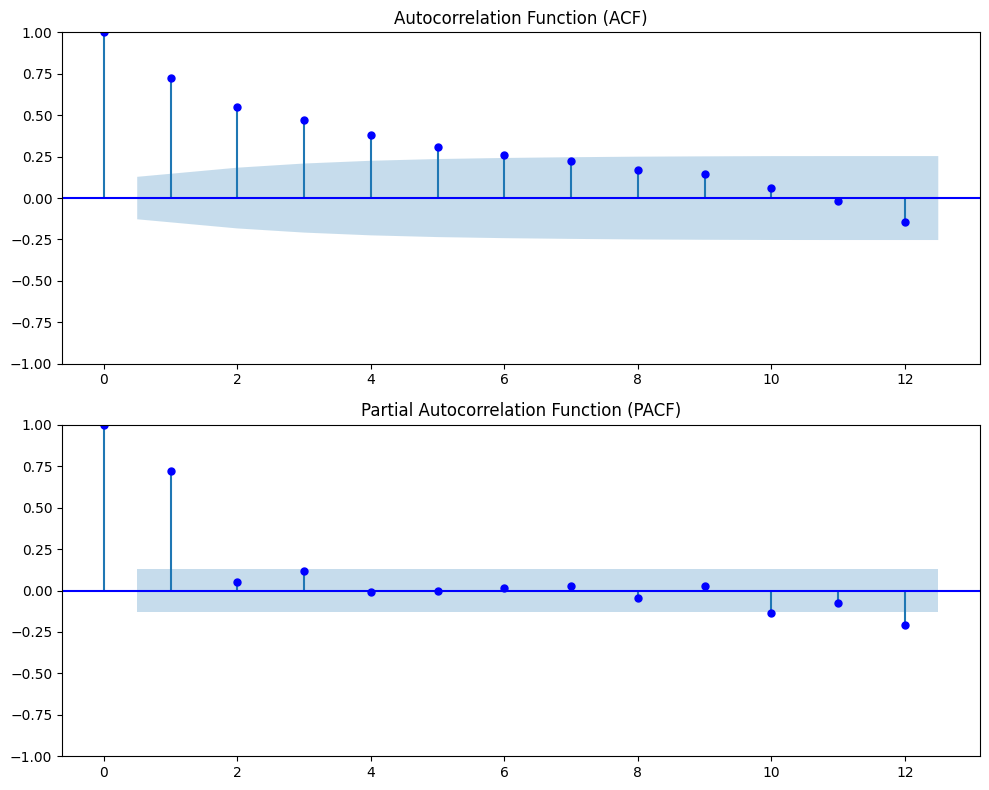

In [6]:
df_a = df.copy().dropna()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

plot_acf(df_a['ln_diff12'], lags=12, color='blue', ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')


plot_pacf(df_a['ln_diff12'], lags=12, color='blue', ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout() 
plt.show()

In the ACF plot we can see that the first 5 show strong correlation and it slowly decreases. This means that the ANNUAL growth of Industrial activity in queretaro is strongly correlated with the growth of past months.

In the PACF plot shows the first autocorrelation to be strong and significant, so we can set and start our ARIMA model with  p=2 and q=0.

### First ARIMA model

In [7]:
p = 1
d = 0 
q = 0
P = 0
D = 1
Q = 0
s = 12

model = sm.tsa.statespace.SARIMAX(df_a['ln_valor'], order=(p,d,q), seasonal_order = (P,D,Q,s), trend='c')
fitmodel = model.fit(disp = 0, method='bfgs')

C:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [8]:
print(fitmodel.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           ln_valor   No. Observations:                  234
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 12)   Log Likelihood                 313.098
Date:                            Fri, 17 Nov 2023   AIC                           -620.196
Time:                                    21:46:18   BIC                           -609.988
Sample:                                         0   HQIC                          -616.074
                                            - 234                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0053      0.004      1.355      0.175      -0.002       0.013
ar.L1          0.7241      0.035   

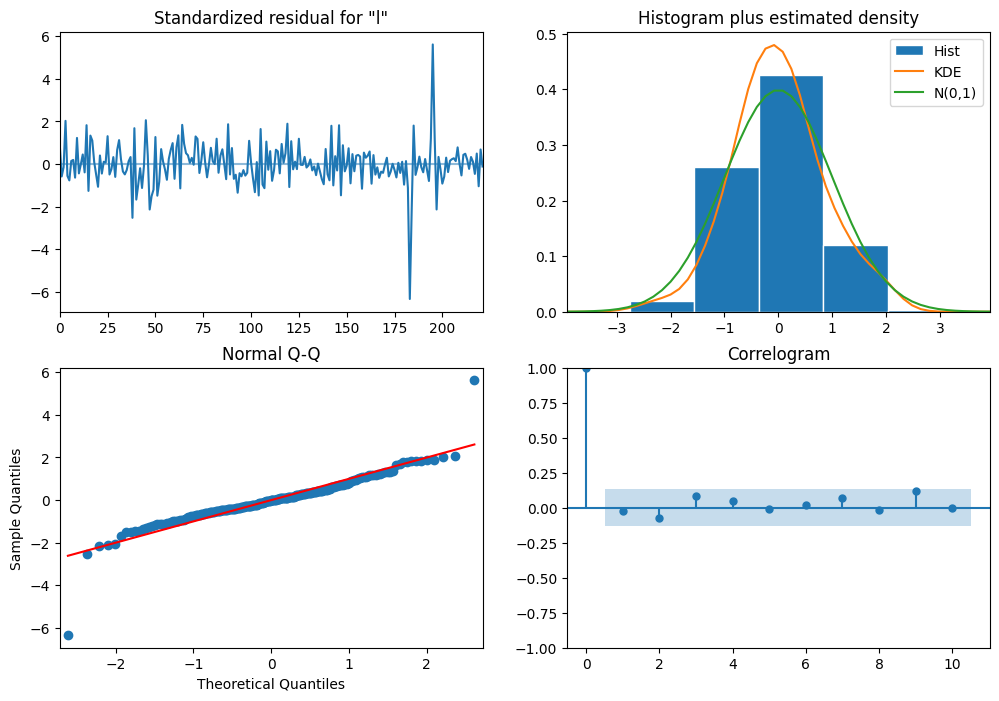

In [9]:
# Plot standardized residuals, Q-Q plot, and Ljung-Box p-values
fitmodel.plot_diagnostics(figsize=(12, 8))
plt.show()

The residuals accross time in the standarized residuals graph seems to behave the same accross all of it except for the two outliers, and the histogram seems to follow a normal distribution of it.

### Conclution.

The intercept in this case 0.053 shows the value of it when all other variables would be equal to 0.
The AR(1) coefficient is 0.7241, it shows the magnitude and direction of the dependence of the time series on the immediate past (lag 1). In this case, it suggests a strong positive dependence.
The sigma 2 shows the variance that our model cannot explain as it is a small number shows that our model is capturing quite good the varaince of our data.
Since the p value Ljung-Box isn´t small enough to reject the hypothesis to reject the null hypothesis that there is not strong autocorrelation in the residuals of our model

### Growth for 6-7 years

C:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


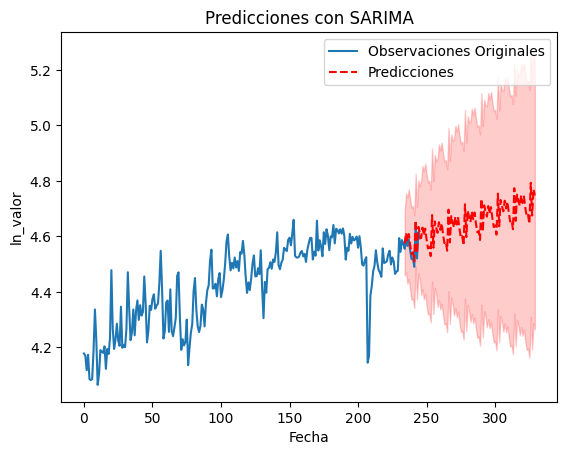

In [32]:
# Hacer predicciones para 96 steps (o cualquier cantidad deseada)
forecast_steps = 96
forecast_results = fitmodel.get_forecast(steps=forecast_steps)

# Obtener la media y los intervalos de confianza
forecast_mean = forecast_results.predicted_mean
forecast_ci = forecast_results.conf_int()

# Graficar las observaciones originales y las predicciones
plt.plot(df['ln_valor'], label='Observaciones Originales')
plt.plot(forecast_mean.index, forecast_mean, label='Predicciones', linestyle='dashed', color='red')

# Rellenar el área entre los intervalos de confianza
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='red', alpha=0.2)

# Añadir etiquetas y leyenda
plt.xlabel('Fecha')
plt.ylabel('ln_valor')
plt.title('Predicciones con SARIMA')
plt.legend()

# Mostrar la gráfica
plt.show()